
Модель **GPT-1 (Generative Pretrained Transformer)** — это первая реализация идеи создания языковой модели на основе архитектуры **Transformer Decoder**, предложенной в работе *“Improving Language Understanding by Generative Pre-Training”* (OpenAI, 2018).
Она заложила фундамент всех последующих поколений GPT-моделей, показав, что модель, обученная на большом корпусе текстов в режиме **предсказания следующего токена**, способна эффективно адаптироваться к различным задачам обработки естественного языка.

# Архитектура
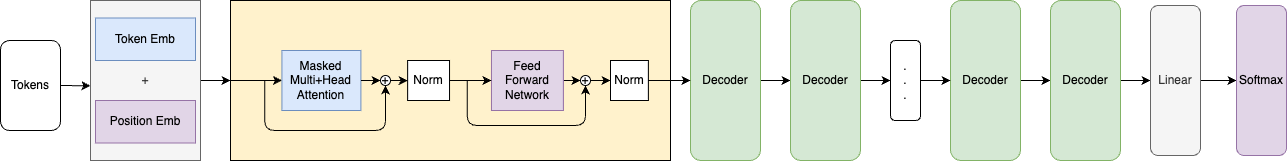

In [1]:
import dill
from torch import nn
import torch

## BPE Tokenizator

In [2]:
class BPE:
    def __init__(self, vocab_size: int):
        self.vocab_size = vocab_size
        self.id2token = {}
        self.token2id = {}

    def fit(self, text: str):
        # 1. Получаем уникальные токены (символы)
        unique_tokens = sorted(set(text))
        tokens = unique_tokens.copy()

        # 2. Разбиваем текст на токены-символы
        sequence = list(text)

        # 3. Объединяем токены до достижения нужного размера словаря
        while len(tokens) < self.vocab_size:
            #print(f'len={len(tokens)} < {self.vocab_size}')
            # Считаем частоты пар
            pair_freq = {}
            for i in range(len(sequence) - 1):
                pair = (sequence[i], sequence[i + 1])
                #print(f'pair = {pair}')
                if pair not in pair_freq:
                    pair_freq[pair] = 0
                pair_freq[pair] += 1


            #print(f'pair_freq = {pair_freq}')  
            if not pair_freq:
                break  # нет пар — выходим

            #for x in pair_freq.items():
            #    self.debug(x, sequence)

            # Находим самую частую пару (в случае равенства — та, что встретилась первой)
            most_frequent_pair = max(pair_freq.items(), key=lambda x: (x[1], -self._pair_first_index(sequence, x[0])))[0]
            #print(most_frequent_pair)
            # Создаем новый токен
            new_token = most_frequent_pair[0] + most_frequent_pair[1]
            #print(f"new token={new_token}")
            tokens.append(new_token)
            #print(f"tokens={tokens}")

            i = 0
            new_sequence = []

            while i < len(sequence):
                if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == most_frequent_pair:
                    new_sequence.append(new_token)
                    i += 2  # пропускаем два символа — заменённую пару
                else:
                    new_sequence.append(sequence[i])
                    i += 1
            sequence = new_sequence
            #break
        
        # 4. Создаем словари
        self.vocab = tokens.copy()
        self.token2id = dict(zip(tokens, range(self.vocab_size)))
        self.id2token = dict(zip(range(self.vocab_size), tokens))

    def _pair_first_index(self, sequence, pair):
        for i in range(len(sequence) - 1):
            if (sequence[i], sequence[i + 1]) == pair:
                return i
        return float('inf')  # если пара не найдена (в теории не должно случиться)


    def encode(self, text: str):
        # 1. Разбиваем текст на токены-символы
        sequence = list(text)
        # 2. Инициализация пустого списка токенов
        tokens = []
        # 3. Установить i = 0
        i = 0
        while i < len(text):
            # 3.1 Найти все токены в словаре, начинающиеся с text[i]
            start_char = text[i]
            result = [token for token in self.vocab if token.startswith(start_char)]
            # 3.2 Выбрать самый длинный подходящий токен
            find_token = self._find_max_matching_token(text[i:], result)
            if find_token is None:
                # Обработка неизвестного символа
                tokens.append(text[i])  # Добавляем сам символ как токен
                i += 1
            else:
                # 3.3 Добавить токен в результат
                tokens.append(find_token)
                # 3.4 Увеличить i на длину токена
                i += len(find_token)

        # 4. Заменить токены на их ID
        return self._tokens_to_ids(tokens)

    def _find_max_matching_token(self, text: str, tokens: list):
        """Находит самый длинный токен из списка, с которого начинается текст"""
        matching = [token for token in tokens if text.startswith(token)]
        return max(matching, key=len) if matching else None

    def _tokens_to_ids(self, tokens):
        """Конвертирует список токенов в их ID с обработкой неизвестных токенов"""
        ids = []
        for token in tokens:
            if token in self.token2id:
                ids.append(self.token2id[token])
            else:
                ids.append(0)  # Специальное значение
        return ids


    def decode(self, ids: list) -> str:
        return ''.join(self._ids_to_tokens(ids))

    def _ids_to_tokens(self, ids: list) -> list:
        """Конвертирует список Ids в их tokens"""
        tokens = []
        for id in ids:
            if id in self.id2token:
                tokens.append(self.id2token[id])
            else:
                tokens.append('')  # Специальное значение
        return tokens


    def save(self, filename):
        with open(filename, 'wb') as f:
            dill.dump(self, f)
        print(f"Объект сохранён в {filename}")


    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            obj = dill.load(f)
                
        print(f"Объект загружен из {filename}")
        return obj

# Архитектура GPT-1: Принципы работы и ключевые компоненты

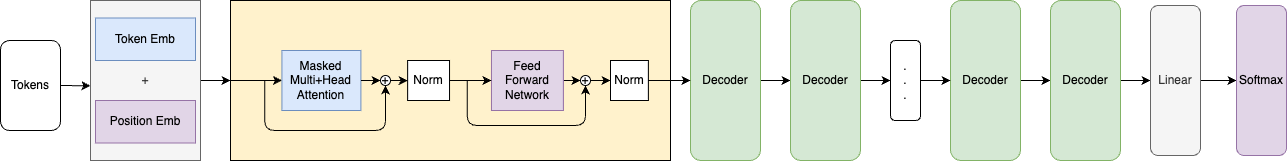

Модель **GPT-1 (Generative Pretrained Transformer)** — это первая версия архитектуры семейства GPT, основанная на **декодере трансформера**.  
Она была представлена исследователями **OpenAI** в 2018 году и стала основой для всех последующих моделей, включая GPT-2, GPT-3 и GPT-4.  

Главная идея GPT-1 заключается в том, что модель можно обучить **понимать и генерировать текст**, если она научится предсказывать **следующий токен** в последовательности.  
Этот простой принцип позволил создать универсальную языковую модель, способную решать множество задач без ручного проектирования под каждую из них.


## 1. Эмбеддинги (Embeddings)


![](https://ucarecdn.com/4ce51ba3-83fc-46c3-a6e8-efa064663df0/)

Перед тем как текст подается в трансформер, его необходимо преобразовать в числовое представление.  
Это делается с помощью **эмбеддингов** — плотных векторов, которые кодируют смысл и структуру слов.

GPT использует два типа эмбеддингов:

### 1.1 Token Embeddings

Каждое слово или подслово сначала токенизируется и преобразуется в уникальный числовой идентификатор.  
Затем этот идентификатор сопоставляется с вектором фиксированной длины — **эмбеддингом токена**.  

Вектор можно рассматривать как координаты слова в многомерном пространстве смыслов: токены, близкие по значению, располагаются рядом.

Формально:
$$
E_{token}(t_i) = W_e[t_i]
$$

где  
$W_e$ — обучаемая матрица эмбеддингов (размером `vocab_size × d_model`),  
$t_i$ — индекс токена в словаре.

In [3]:
class TokenEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super().__init__()
        self._embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=emb_size,
            padding_idx=0  # чтобы 0 можно было безопасно использовать
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self._embedding(x)

### 1.2 Positional Embeddings

Архитектура трансформера не учитывает порядок слов, так как внимание обрабатывает все токены параллельно.  
Чтобы сохранить последовательность, вводятся **позиционные эмбеддинги**, которые добавляют информацию о позиции каждого токена.

В GPT-1 используются **синусоиды фиксированной формы**:
$$
PE_{(pos, 2i)} = \sin\left(\frac{pos}{10000^{2i/d_{model}}}\right), \quad
PE_{(pos, 2i+1)} = \cos\left(\frac{pos}{10000^{2i/d_{model}}}\right)
$$

Окончательное представление токена:
$$
x_i = E_{token}(t_i) + PE(pos_i)
$$

In [4]:
class PositionEmbeddings(nn.Module):
    def __init__(self, max_seq_len: int, emb_size: int):
        super().__init__()
        self.max_seq_len = max_seq_len
        self.emb_size = emb_size
        self.embedding = nn.Embedding(
            num_embeddings=max_seq_len,
            embedding_dim=emb_size
        )

    def forward(self, seq_len: int) -> torch.Tensor:
        if seq_len < 1 or seq_len > self.max_seq_len:
            raise IndexError(f"Длина {seq_len} должна быть от 1 до {self.max_seq_len}")
        positions = torch.arange(seq_len, device=self.embedding.weight.device)
        return self.embedding(positions)

## 2. Внимание (Attention)


![](https://ucarecdn.com/538faeda-c12d-4137-9f67-e87720d83e13/)

Механизм внимания — ключевая идея трансформеров.  
Он позволяет модели **взвешивать важность других токенов** при обработке текущего, то есть решать, на какие слова нужно обратить внимание при генерации следующего.

---

### 2.1 Матрица внимания

Каждому токену сопоставляются три обучаемых вектора:
- **Query (Q)** — запрос: что текущий токен ищет в других;
- **Key (K)** — ключ: какую информацию несет токен;
- **Value (V)** — значение: само содержимое токена.

Эти векторы вычисляются линейными преобразованиями входных эмбеддингов:
$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

Затем вычисляется **взвешенное внимание**:
$$
\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V
$$

---

### 2.2 Матричные операции

- $QK^T$ — матрица сходства между токенами;  
- деление на $\sqrt{d_k}$ стабилизирует градиенты;  
- **softmax** превращает оценки в вероятности;  
- умножение результата на $V$ даёт взвешенные представления токенов.



In [5]:
class HeadAttention(nn.Module):
    def __init__(self, emb_size: int, head_size: int, max_seq_len: int):
        super().__init__()
        self._emb_size = emb_size
        self._head_size = head_size
        self._max_seq_len = max_seq_len

        # Линейные преобразования для Q, K, V
        self._k = nn.Linear(emb_size, head_size)
        self._q = nn.Linear(emb_size, head_size)
        self._v = nn.Linear(emb_size, head_size)

        # Создание causal маски
        mask = torch.tril(torch.ones(max_seq_len, max_seq_len))
        self.register_buffer('_tril_mask', mask.bool() if hasattr(torch, 'bool') else mask.byte())

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        seq_len = x.shape[1]
        if seq_len > self._max_seq_len:
            raise ValueError(f"Длина последовательности {seq_len} превышает максимум {self._max_seq_len}")

        # 1. Линейные преобразования
        k = self._k(x)  # [B, T, hs]
        q = self._q(x)  # [B, T, hs]
        
        # 2. Вычисление scores
        scores = q @ k.transpose(-2, -1) / self._head_size ** 0.5
        
        # 3. Применение causal маски
        scores = scores.masked_fill(~self._tril_mask[:seq_len, :seq_len], float('-inf'))
        
        # 4. Softmax и умножение на V
        weights = F.softmax(scores, dim=-1)
        return weights @ self._v(x)

### 2.3 Мультихед (Multi-Head Attention)

Вместо одной операции внимания GPT-1 использует несколько параллельных **голов внимания**.  
Каждая голова фокусируется на различных аспектах контекста — синтаксисе, семантике или долгосрочных зависимостях.

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W_O
$$

где каждая голова:
$$
\text{head}_i = \text{Attention}(QW_{Qi}, KW_{Ki}, VW_{Vi})
$$

В GPT-1 используется **12 голов**, что обеспечивает богатое контекстное восприятие текста.

In [6]:

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, emb_size: int, head_size: int, max_seq_len: int, dropout: float = 0.1):
        super().__init__()
        self._heads = nn.ModuleList([
            HeadAttention(
                emb_size=emb_size, 
                head_size=head_size, 
                max_seq_len=max_seq_len
            ) for _ in range(num_heads)
        ])
        self._layer = nn.Linear(head_size * num_heads, emb_size)
        self._dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        # 1. Вычисляем attention для каждой головы
        attention_outputs = [head(x) for head in self._heads]
        
        # 2. Объединяем результаты всех голов
        concatenated_attention = torch.cat(attention_outputs, dim=-1)
        
        # 3. Проецируем в пространство эмбеддингов
        projected_output = self._layer(concatenated_attention)
        
        # 4. Применяем dropout для регуляризации
        final_output = self._dropout(projected_output)
        
        return final_output

## 3. Feed Forward Network (FFN)

![](https://ucarecdn.com/6af52549-95fa-45be-9764-9c399f387aa6/)

После блока внимания каждый токен независимо проходит через двухслойную нейронную сеть — **Feed Forward Network**.  
Она добавляет модели способность нелинейно преобразовывать информацию.

$$
\text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2
$$

Используется активация **ReLU**.  
FFN применяется одинаково к каждому токену и не зависит от порядка слов, что делает вычисления высокопараллельными.


In [7]:
class FeedForward(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.1):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(emb_size, 4 * emb_size),
            nn.ReLU(),
            nn.Linear(4 * emb_size, emb_size),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor):
        self.net = self.net.to(x.dtype)
        return self.net(x)

## 4. Блок Декодера


![](https://ucarecdn.com/c7cc9bf3-cc75-4fac-97a9-ce122c74738e/)


Каждый слой GPT-1 — это **декодер**, состоящий из следующих элементов:

1. **Masked Multi-Head Attention**  
   Маска запрещает токену видеть будущие позиции, чтобы сохранить авторегрессионное направление генерации (слева направо).

2. **Остаточные связи + Layer Normalization**  
   Результат внимания складывается с входом слоя, а затем нормализуется:  
   $$
   x' = \text{LayerNorm}(x + \text{Attention}(x))
   $$

3. **Feed Forward + Residual + LayerNorm**  
   $$
   y = \text{LayerNorm}(x' + \text{FFN}(x'))
   $$

GPT-1 содержит **12 таких блоков**, соединённых последовательно.

In [8]:
class Decoder(nn.Module):
    def __init__(self, 
        num_heads: int,
        emb_size: int,
        head_size: int,
        max_seq_len: int,
        dropout: float = 0.1
    ):
        super().__init__()
        self._heads = MultiHeadAttention(
            num_heads=num_heads, 
            emb_size=emb_size, 
            head_size=head_size, 
            max_seq_len=max_seq_len, 
            dropout=dropout
        )
        self._ff = FeedForward(
            emb_size=emb_size, 
            dropout=dropout
        )
        self._norm1 = nn.LayerNorm(emb_size)
        self._norm2 = nn.LayerNorm(emb_size)
        #self._dropout_attn = nn.Dropout(dropout)
        #self._dropout_ffn = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None):
        # Приведение типов параметров
        self._heads = self._heads.to(x.dtype)
        self._ff = self._ff.to(x.dtype)
        
        # Пропустим тензор x через экземпляр MultiHeadAttention.
        attention = self._heads(x, mask)
        #attention = self._dropout_attn(attention)
        
        # Выходной тензор из блока внимания сложим с исходным x.
        out = attention + x
        
        # Получившийся тензор пропустим через первый слой нормализации.
        norm_out = self._norm1(out)
        
        # Затем подадим его на вход экземпляру FFN.
        ffn_out = self._ff(norm_out)
        #ffn_out = self._dropout_ffn(ffn_out)
        
        # Выходной тензор из FFN сложим с тем, что поступил на вход.
        out = ffn_out + norm_out
        
        # Пропустим получившийся тензор через второй слой нормализации.
        norm_out = self._norm2(out)
        
        # Вернем итоговый тензор размером batch_size x seq_len x emb_size.
        return norm_out

## 5. Обучение GPT-1

GPT-1 обучается в два этапа:

- 1️⃣ **Предобучение (Unsupervised Pretraining)**  
- 2️⃣ **Дообучение (Supervised Fine-Tuning)**


In [9]:
class GPT(nn.Module):
    """GPT-like трансформер для генерации текста
    
    Args:
        vocab_size: Размер словаря
        max_seq_len: Макс. длина последовательности
        emb_size: Размерность эмбеддингов
        num_heads: Количество голов внимания
        head_size: Размерность голов внимания
        num_layers: Количество слоёв декодера
        dropout: Вероятность dropout (default=0.1)
        device: Устройство (default='cpu')
    """
    def __init__(self,
        vocab_size: int,
        max_seq_len: int,
        emb_size: int,
        num_heads: int,
        head_size: int,
        num_layers: int,
        dropout: float = 0.1,
        device: str = 'cpu'
    ):
        super().__init__()
        self.device = device
        self.max_seq_len = max_seq_len
        
        # Инициализация слоев
        self._token_embeddings = TokenEmbeddings(
            vocab_size=vocab_size, 
            emb_size=emb_size
        )
        self._position_embeddings = PositionEmbeddings(
            max_seq_len=max_seq_len, 
            emb_size=emb_size
        )
        self._dropout = nn.Dropout(dropout)
        self._decoders = nn.ModuleList([Decoder(
            num_heads=num_heads,
            emb_size=emb_size,
            head_size=head_size,
            max_seq_len=max_seq_len,
            dropout=dropout 
        ) for _ in range(num_layers)])
        self._linear = nn.Linear(emb_size, vocab_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """Прямой проход через GPT
        
        Args:
            x: Входной тензор [batch_size, seq_len]
            
        Returns:
            Тензор логитов [batch_size, seq_len, vocab_size]
        """
        # Проверка длины последовательности
        if x.size(1) > self.max_seq_len:
            raise ValueError(f"Длина последовательности {x.size(1)} превышает максимальную {self.max_seq_len}")
        
        # Эмбеддинги токенов и позиций
        tok_out = self._token_embeddings(x)  # [batch, seq_len, emb_size]
        pos_out = self._position_embeddings(x.size(1))  # [seq_len, emb_size]
        
        # Комбинирование
        out = self._dropout(tok_out + pos_out.unsqueeze(0))  # [batch, seq_len, emb_size]
        
        # Стек декодеров
        for decoder in self._decoders:
            out = decoder(out)
            
        return self._linear(out)  # [batch, seq_len, vocab_size]

    def generate(self, x: torch.Tensor, max_new_tokens: int):
        for _ in range(max_new_tokens):
            # 1. Обрезаем вход, если последовательность слишком длинная
            x_cond = x[:, -self.max_seq_len:]

            # 2. Передаем последовательность в метод forward класса GPT и полуаем логиты.
            logits = self.forward(x_cond)

            # 3. Берем логиты для последнего токена
            last_logits = logits[:, -1, :]  # [batch_size, vocab_size]

            # 4. Применяем Softmax
            probs = F.softmax(last_logits, dim=-1)  # [batch_size, vocab_size]

            # 5. Выбираем токен с максимальной вероятностью
            next_token = torch.argmax(probs, dim=-1, keepdim=True)  # [batch_size, 1]

            # 6. Добавляем его к последовательности
            x = torch.cat([x, next_token], dim=1)  # [batch_size, seq_len+1]     
        return x



### 5.1 Предобучение

На первом этапе модель обучается без разметки: она получает большой корпус текстов и учится **предсказывать следующий токен** по предыдущим.

Функция потерь:
$$
L = - \sum_{t=1}^{T} \log P(x_t | x_1, x_2, ..., x_{t-1})
$$

Таким образом, модель учится строить вероятностную модель языка, "угадывая" продолжение текста.


Во время **предобучения** GPT-1 учится **предсказывать следующий токен** (language modeling task).  
Формально:  
$$ 
P(x_t ,|, x_1, x_2, \dots, x_{t-1})  
$$ 
То есть, если на вход подаётся предложение `"I love deep"`, модель должна предсказать `"learning"`.


### ✅ 5.1.1 Подготовка данных

Создадим **датасет** на основе BPE-токенизатора:

In [10]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self, text: str, bpe: BPE, block_size: int):
        self.bpe = bpe
        self.block_size = block_size
        self.data = bpe.encode(text)
        
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.block_size], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.block_size+1], dtype=torch.long)
        return x, y

- `x` — входная последовательность токенов
    
- `y` — та же последовательность, но сдвинутая на один токен вперёд (цель)

### ✅ 5.1.2 Цикл обучения

Для обучения создадим функцию:

In [11]:
import torch.nn.functional as F
from torch import optim

def train_gpt(model, dataset, epochs=5, batch_size=32, lr=3e-4, device='cpu'):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            # Прямой проход
            logits = model(x)  # [B, T, vocab_size]

            # Перестроим выход под CrossEntropy
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))

            # Обратное распространение
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

### ✅ 5.1.3 Пример запуска

In [12]:
# 1. Исходный текст
text = "Deep learning is amazing. Transformers changed the world. Attention is all you need. GPT models revolutionized NLP."

# 2. Обучаем токенизатор
bpe = BPE(vocab_size=100)
bpe.fit(text)

# 3. Создаем датасет
dataset = GPTDataset(text, bpe, block_size=8)
print(f"Dataset length: {len(dataset)}")

# 4. Инициализируем модель
gpt = GPT(
    vocab_size=len(bpe.vocab),
    max_seq_len=8,
    emb_size=64,
    num_heads=4,
    head_size=16,
    num_layers=2,
    dropout=0.1
)

# 5. Обучаем
train_gpt(gpt, dataset, epochs=100, batch_size=4)

Dataset length: 20
Epoch 1/100, Loss: 4.5466
Epoch 2/100, Loss: 4.2532
Epoch 3/100, Loss: 3.9998
Epoch 4/100, Loss: 3.7857
Epoch 5/100, Loss: 3.5823
Epoch 6/100, Loss: 3.3802
Epoch 7/100, Loss: 3.2312
Epoch 8/100, Loss: 3.0589
Epoch 9/100, Loss: 2.8971
Epoch 10/100, Loss: 2.7329
Epoch 11/100, Loss: 2.5889
Epoch 12/100, Loss: 2.4817
Epoch 13/100, Loss: 2.3101
Epoch 14/100, Loss: 2.1343
Epoch 15/100, Loss: 2.0490
Epoch 16/100, Loss: 1.8943
Epoch 17/100, Loss: 1.7862
Epoch 18/100, Loss: 1.6848
Epoch 19/100, Loss: 1.5660
Epoch 20/100, Loss: 1.4896
Epoch 21/100, Loss: 1.3954
Epoch 22/100, Loss: 1.3091
Epoch 23/100, Loss: 1.2422
Epoch 24/100, Loss: 1.1602
Epoch 25/100, Loss: 1.1006
Epoch 26/100, Loss: 1.0547
Epoch 27/100, Loss: 0.9972
Epoch 28/100, Loss: 0.9414
Epoch 29/100, Loss: 0.8983
Epoch 30/100, Loss: 0.8630
Epoch 31/100, Loss: 0.7975
Epoch 32/100, Loss: 0.7723
Epoch 33/100, Loss: 0.7307
Epoch 34/100, Loss: 0.7038
Epoch 35/100, Loss: 0.6767
Epoch 36/100, Loss: 0.6498
Epoch 37/100, Loss

GPT(
  (_token_embeddings): TokenEmbeddings(
    (_embedding): Embedding(100, 64, padding_idx=0)
  )
  (_position_embeddings): PositionEmbeddings(
    (embedding): Embedding(8, 64)
  )
  (_dropout): Dropout(p=0.1, inplace=False)
  (_decoders): ModuleList(
    (0-1): 2 x Decoder(
      (_heads): MultiHeadAttention(
        (_heads): ModuleList(
          (0-3): 4 x HeadAttention(
            (_k): Linear(in_features=64, out_features=16, bias=True)
            (_q): Linear(in_features=64, out_features=16, bias=True)
            (_v): Linear(in_features=64, out_features=16, bias=True)
          )
        )
        (_layer): Linear(in_features=64, out_features=64, bias=True)
        (_dropout): Dropout(p=0.1, inplace=False)
      )
      (_ff): FeedForward(
        (net): Sequential(
          (0): Linear(in_features=64, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=64, bias=True)
          (3): Dropout(p=0.1, inplace=False)
        


---

### 5.2 Дообучение

После предобучения GPT-1 уже знает структуру и грамматику языка.  
На втором этапе она дообучается на конкретных задачах (например, классификация, QA) с помощью размеченных данных.

Технически это почти то же обучение, только:

- Загружаем модель с уже обученными весами.
- Используем новые данные.
- Можно уменьшить скорость обучения.
- Иногда замораживают часть слоёв (например, эмбеддинги).


In [13]:
def fine_tune_gpt(model, dataset, epochs=3, batch_size=16, lr=1e-5, device='cpu', freeze_embeddings=True):
    if freeze_embeddings:
        for param in model._token_embeddings.parameters():
            param.requires_grad = False
        for param in model._position_embeddings.parameters():
            param.requires_grad = False

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Fine-tune Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

In [14]:
# Например, мы хотим дообучить модель на стиле коротких технических фраз
fine_tune_text = """
Transformers revolutionize NLP.
Deep learning enables self-attention.
GPT generates text autoregressively.
"""

dataset = GPTDataset(fine_tune_text, bpe, block_size=8)


# Запуск дообучения
fine_tune_gpt(gpt, dataset, epochs=10, batch_size=4, lr=1e-4)

Fine-tune Epoch 1/10, Loss: 4.3808
Fine-tune Epoch 2/10, Loss: 3.9245
Fine-tune Epoch 3/10, Loss: 3.5217
Fine-tune Epoch 4/10, Loss: 3.2451
Fine-tune Epoch 5/10, Loss: 3.0076
Fine-tune Epoch 6/10, Loss: 2.8133
Fine-tune Epoch 7/10, Loss: 2.6857
Fine-tune Epoch 8/10, Loss: 2.5984
Fine-tune Epoch 9/10, Loss: 2.5168
Fine-tune Epoch 10/10, Loss: 2.4128


## 📝 6. Генерация текста после обучения

In [15]:
def generate_text(model, bpe, prompt: str, max_new_tokens=20, device='cpu'):
    model.eval()
    ids = torch.tensor([bpe.encode(prompt)], dtype=torch.long).to(device)
    out = model.generate(ids, max_new_tokens=max_new_tokens)
    text = bpe.decode(out[0].tolist())
    return text

In [16]:
print(generate_text(gpt, bpe, "Deep learning", max_new_tokens=20))

Deep learning e els revolutionized NLP.
